## **Importing libraries and datasets**

In [1]:
import numpy as np
import pandas as pd
import datetime as dt

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE

from sklearn.linear_model import LogisticRegression
import xgboost as xgb

from sklearn.metrics import precision_score, recall_score, f1_score, auc, roc_auc_score, accuracy_score, classification_report, confusion_matrix, roc_curve
from xgboost import plot_importance


/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
df_response = pd.read_csv('../00_Dataset/Retail_Data_Response.csv')
df_transactions = pd.read_csv('../00_Dataset/Retail_Data_Transactions.csv', parse_dates=['trans_date'])

In [3]:
df_response.head()

customer_id  response
0      CS1112         0
1      CS1113         0
2      CS1114         1
3      CS1115         1
4      CS1116         1

In [4]:
df_transactions.head()

customer_id trans_date  tran_amount
0      CS5295 2013-02-11           35
1      CS4768 2015-03-15           39
2      CS2122 2013-02-26           52
3      CS1217 2011-11-16           99
4      CS1850 2013-11-20           78

In [5]:
print(df_transactions['trans_date'].min())
print(df_transactions['trans_date'].max())

2011-05-16 00:00:00
2015-03-16 00:00:00


## **Data Preparation**

In [6]:
## since the last date of the data is 16 March 2015, the campaign date is assumed to be 17 March 2015
## RFM model will be used to predict campaign response. Recency is calculated

campaign_date = dt.datetime(2015,3,17)
df_transactions['recent']= campaign_date - df_transactions['trans_date']
df_transactions['recent'].astype('timedelta64[D]')
df_transactions['recent']=df_transactions['recent'] / np.timedelta64(1, 'D')
df_transactions.head()

customer_id trans_date  tran_amount  recent
0      CS5295 2013-02-11           35   764.0
1      CS4768 2015-03-15           39     2.0
2      CS2122 2013-02-26           52   749.0
3      CS1217 2011-11-16           99  1217.0
4      CS1850 2013-11-20           78   482.0

In [7]:
## create data set with RFM variables

df_rfm = df_transactions.groupby('customer_id').agg({'recent': lambda x:x.min(),                      # Recency
                                                     'customer_id': lambda x: len(x),                 # Frequency
                                                     'tran_amount': lambda x: x.sum()})               # Monetary Value           


df_rfm.rename(columns={'recent': 'recency', 
                       'customer_id': 'frequency', 
                       'tran_amount': 'monetary_value'}, inplace=True)

In [8]:
df_rfm = df_rfm.reset_index()
df_rfm.head()

customer_id  recency  frequency  monetary_value
0      CS1112     62.0         15            1012
1      CS1113     36.0         20            1490
2      CS1114     33.0         19            1432
3      CS1115     12.0         22            1659
4      CS1116    204.0         13             857

In [9]:
## create data set with CLV variables

df_clv = df_transactions.groupby('customer_id').agg({'recent': lambda x:x.min(),                      # Recency
                                                     'customer_id': lambda x: len(x),                 # Frequency
                                                     'tran_amount': lambda x: x.sum(),                # Monetary Value           
                                                     'trans_date': lambda x: (x.max() - x.min()).days})       # AOU

df_clv.rename(columns={'recent': 'recency', 
                       'customer_id': 'frequency', 
                       'tran_amount': 'monetary_value',
                       'trans_date' : 'AOU'}, inplace=True)

df_clv['ticket_size'] = df_clv['monetary_value'] / df_clv['frequency']

In [10]:
df_clv = df_clv.reset_index()
df_clv.head()

customer_id  recency  frequency  monetary_value   AOU  ticket_size
0      CS1112     62.0         15            1012  1309    67.466667
1      CS1113     36.0         20            1490  1354    74.500000
2      CS1114     33.0         19            1432  1309    75.368421
3      CS1115     12.0         22            1659  1303    75.409091
4      CS1116    204.0         13             857  1155    65.923077

In [35]:
df_trans_l3 = df_transactions[df_transactions['trans_date']>=campaign_date - pd.offsets.MonthBegin(3)].groupby(by=['customer_id'])['tran_amount'].agg(['mean','median','count','max','min']).reset_index()
df_trans_l3.columns = ['customer_id','l3_mean_amount','l3_med_amount','l3_num_trans','l3_max_amount','l3_min_amount'] 

df_trans_l6 = df_transactions[df_transactions['trans_date']>=campaign_date - pd.offsets.MonthBegin(6)].groupby(by=['customer_id'])['tran_amount'].agg(['mean','median','count','max','min']).reset_index()
df_trans_l6.columns = ['customer_id','l6_mean_amount','l6_med_amount','l6_num_trans','l6_max_amount','l6_min_amount'] 

df_trans_l12 = df_transactions[df_transactions['trans_date']>=campaign_date - pd.offsets.MonthBegin(12)].groupby(by=['customer_id'])['tran_amount'].agg(['mean','median','count','max','min']).reset_index()
df_trans_l12.columns = ['customer_id','l12_mean_amount','l12_med_amount','l12_num_trans','l12_max_amount','l12_min_amount'] 

# df_trans = df_transactions.groupby(by=['customer_id'])['tran_amount'].agg(['mean','median','max','min','std']).reset_index()
# df_trans.columns = ['customer_id','mean_amount','med_amount','max_amount','min_amount','std_amount'] 

In [36]:
df_new = df_clv.merge(df_trans_l3,how="left",on='customer_id').merge(df_trans_l6,how="left",on='customer_id').merge(df_trans_l12,how="left",on='customer_id')
# .merge(df_trans,how="left",on='customer_id')
df_new = df_new.fillna(0)
df_new

customer_id  recency  ...  l12_max_amount  l12_min_amount
0         CS1112     62.0  ...            90.0            39.0
1         CS1113     36.0  ...            98.0            36.0
2         CS1114     33.0  ...            95.0            37.0
3         CS1115     12.0  ...            98.0            55.0
4         CS1116    204.0  ...            90.0            40.0
...          ...      ...  ...             ...             ...
6884      CS8996     98.0  ...            79.0            30.0
6885      CS8997    262.0  ...            45.0            45.0
6886      CS8998     85.0  ...            49.0            13.0
6887      CS8999    258.0  ...            18.0            18.0
6888      CS9000     17.0  ...            35.0            20.0

[6889 rows x 21 columns]

## **Calculating response rate**

In [37]:
response_rate = df_response.groupby('response').agg({'customer_id': lambda x: len(x)}).reset_index()
response_rate.head()

response  customer_id
0         0         6237
1         1          647

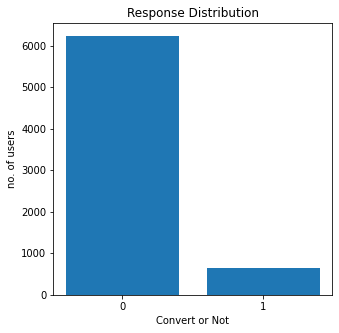

In [38]:
plt.figure(figsize=(5,5))
x=range(2)
plt.bar(x,response_rate['customer_id'])
plt.xticks(response_rate.index)
plt.title('Response Distribution')
plt.xlabel('Convert or Not')
plt.ylabel('no. of users')
plt.show()

## data is imbalanced

In [39]:
## merging two data sets - RFM

df_modeling_rfm = pd.merge(df_response,df_rfm)
df_modeling_rfm.head()

customer_id  response  recency  frequency  monetary_value
0      CS1112         0     62.0         15            1012
1      CS1113         0     36.0         20            1490
2      CS1114         1     33.0         19            1432
3      CS1115         1     12.0         22            1659
4      CS1116         1    204.0         13             857

In [40]:
## merging two data sets - CLV

df_modeling_clv = pd.merge(df_response,df_clv)
df_modeling_clv.head()

customer_id  response  recency  frequency  monetary_value   AOU  ticket_size
0      CS1112         0     62.0         15            1012  1309    67.466667
1      CS1113         0     36.0         20            1490  1354    74.500000
2      CS1114         1     33.0         19            1432  1309    75.368421
3      CS1115         1     12.0         22            1659  1303    75.409091
4      CS1116         1    204.0         13             857  1155    65.923077

In [41]:
## merging two data sets - NEW
df_modeling_new = pd.merge(df_response,df_new)
df_modeling_new.head()

customer_id  response  recency  ...  l12_num_trans  l12_max_amount  l12_min_amount
0      CS1112         0     62.0  ...            4.0            90.0            39.0
1      CS1113         0     36.0  ...            6.0            98.0            36.0
2      CS1114         1     33.0  ...            5.0            95.0            37.0
3      CS1115         1     12.0  ...            3.0            98.0            55.0
4      CS1116         1    204.0  ...            3.0            90.0            40.0

[5 rows x 22 columns]

In [42]:
df_modeling_new.columns

Index(['customer_id', 'response', 'recency', 'frequency', 'monetary_value',
       'AOU', 'ticket_size', 'l3_mean_amount', 'l3_med_amount', 'l3_num_trans',
       'l3_max_amount', 'l3_min_amount', 'l6_mean_amount', 'l6_med_amount',
       'l6_num_trans', 'l6_max_amount', 'l6_min_amount', 'l12_mean_amount',
       'l12_med_amount', 'l12_num_trans', 'l12_max_amount', 'l12_min_amount'],
      dtype='object')

## **Creating train and test dataset**

In [43]:
## spliting dataframe into X and y

X_rfm = df_modeling_rfm.drop(columns=['response','customer_id'])
y_rfm = df_modeling_rfm['response']

X_clv = df_modeling_clv.drop(columns=['response','customer_id'])
y_clv = df_modeling_clv['response']

X_new = df_modeling_new.drop(columns=['response','customer_id'])
y_new = df_modeling_new['response']

In [44]:
## creating train and test dataset

X_train_rfm, X_test_rfm, y_train_rfm, y_test_rfm = train_test_split(X_rfm, y_rfm, test_size=0.3, random_state=0)
X_train_clv, X_test_clv, y_train_clv, y_test_clv = train_test_split(X_clv, y_clv, test_size=0.3, random_state=0)
X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(X_new, y_new, test_size=0.3, random_state=0)


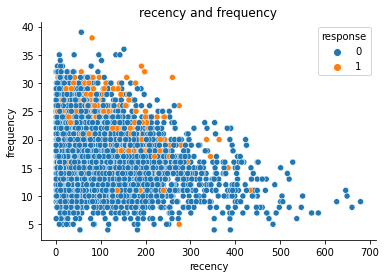

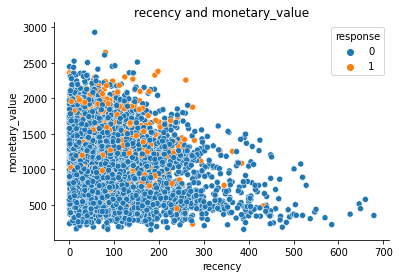

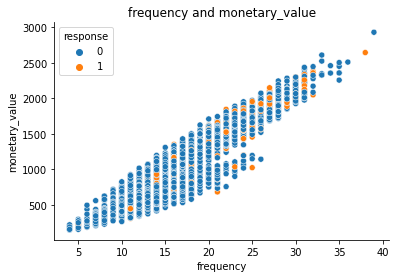

In [21]:
for i, col_i in enumerate(df_modeling_rfm[['recency', 'frequency', 'monetary_value']].columns):
  for j, col_j in enumerate(df_modeling_rfm[['recency', 'frequency', 'monetary_value']].columns):
    if i < j :
      plt.title(col_i + ' and ' + col_j)
      sns.scatterplot(data=df_modeling_rfm, x=col_i, y=col_j, hue='response')
      sns.despine()
      plt.show()

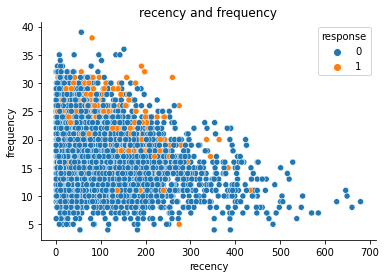

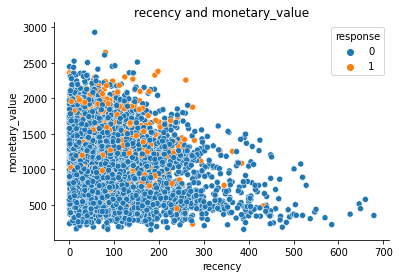

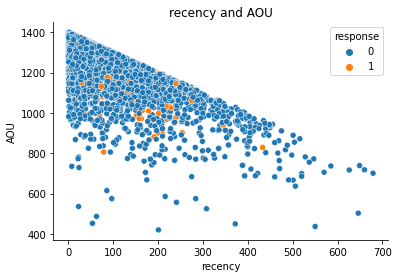

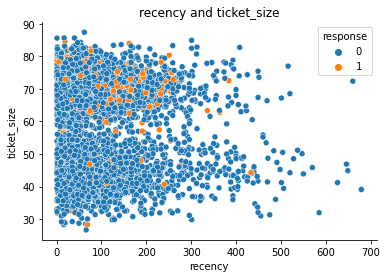

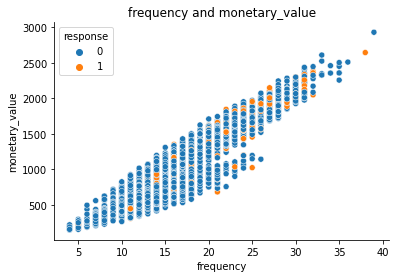

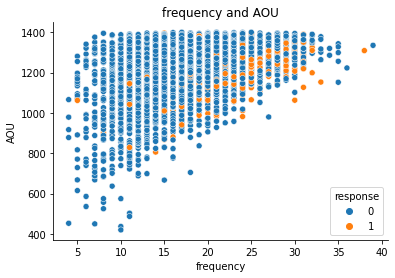

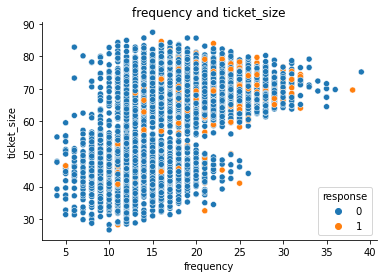

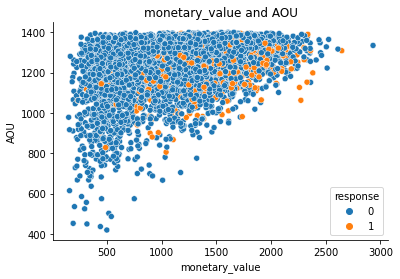

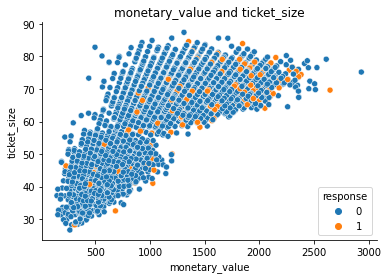

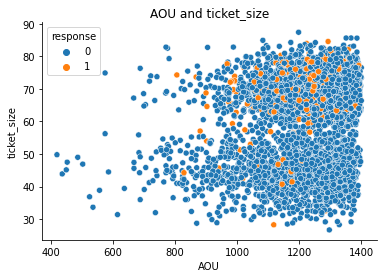

In [22]:
for i, col_i in enumerate(df_modeling_clv[['recency', 'frequency', 'monetary_value', 'AOU', 'ticket_size']].columns):
  for j, col_j in enumerate(df_modeling_clv[['recency', 'frequency', 'monetary_value', 'AOU', 'ticket_size']].columns):
    if i < j :
      plt.title(col_i + ' and ' + col_j)
      sns.scatterplot(data=df_modeling_clv, x=col_i, y=col_j, hue='response')
      sns.despine()
      plt.show()

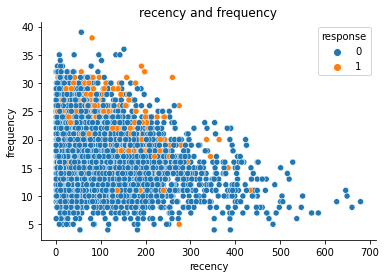

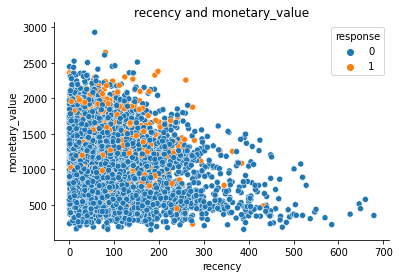

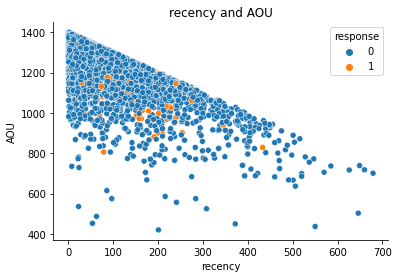

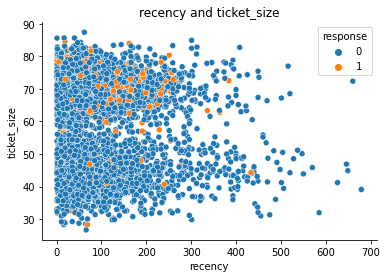

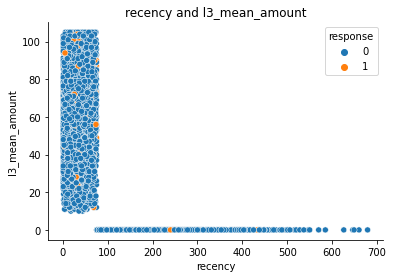

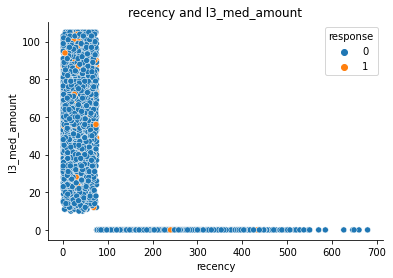

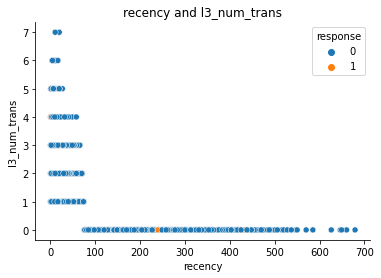

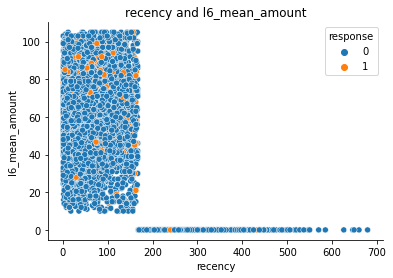

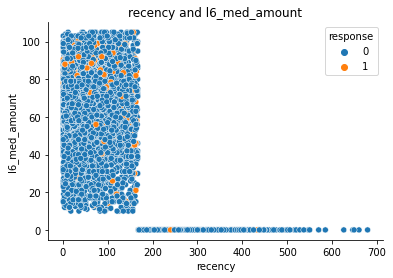

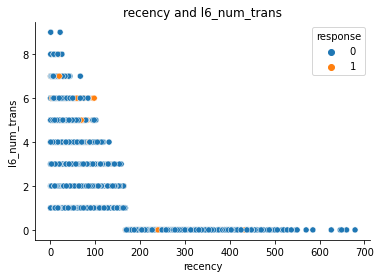

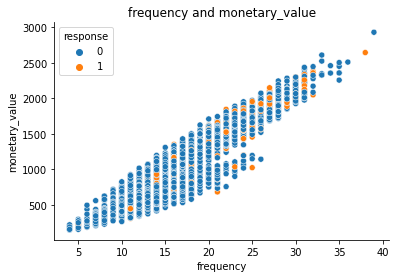

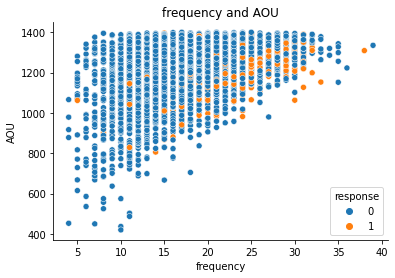

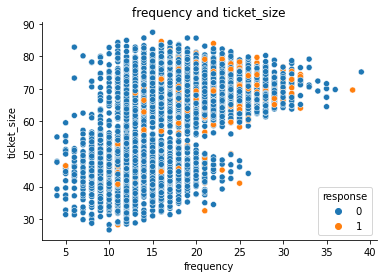

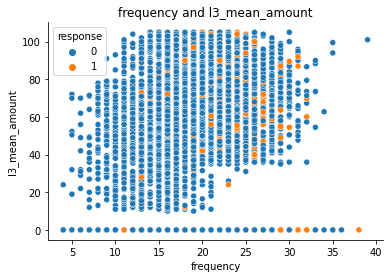

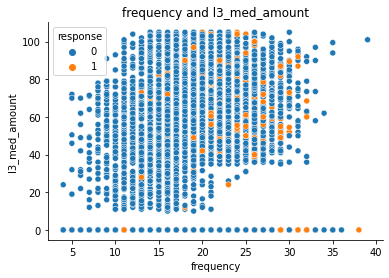

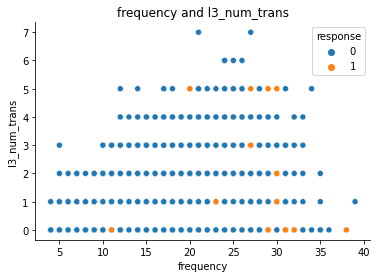

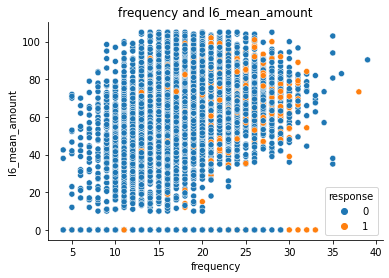

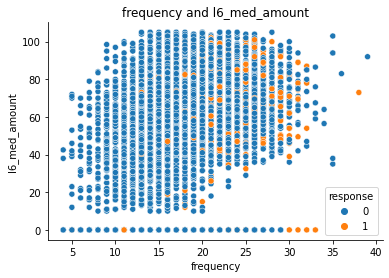

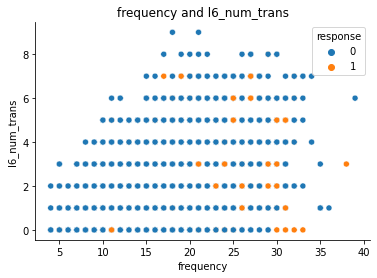

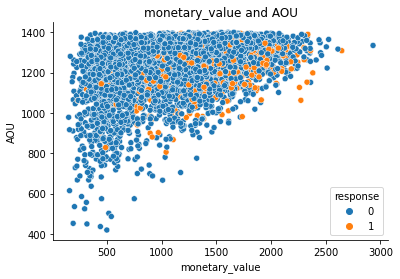

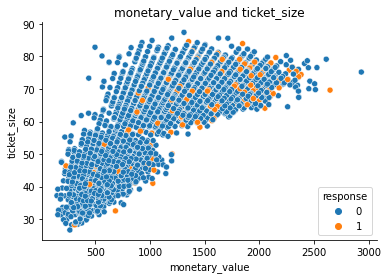

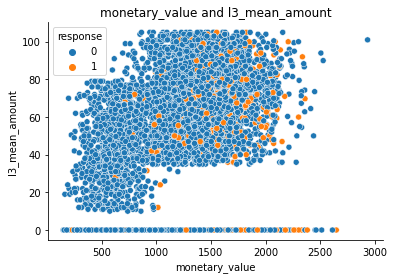

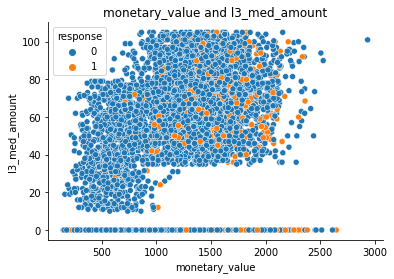

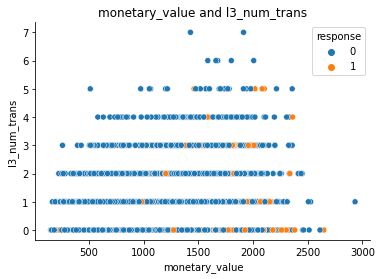

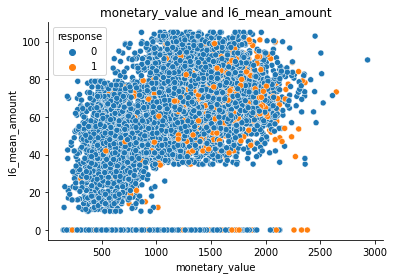

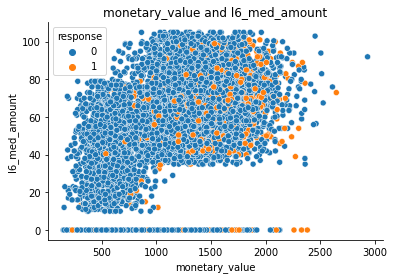

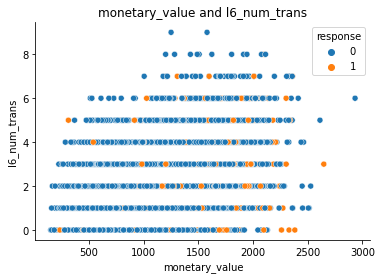

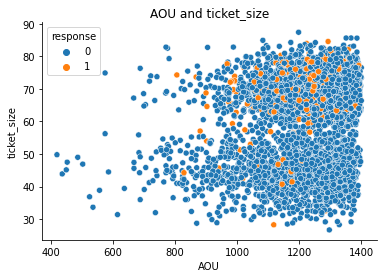

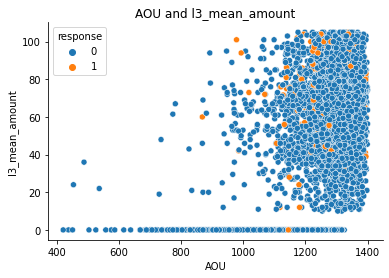

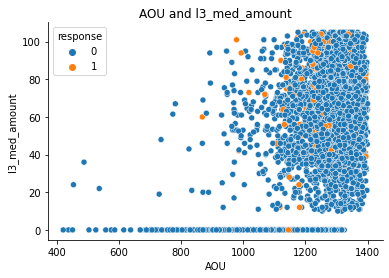

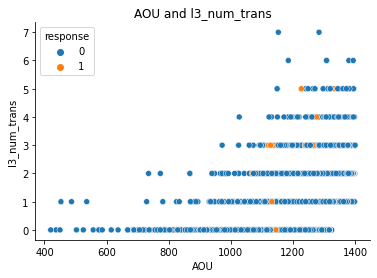

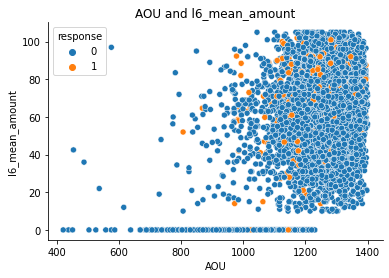

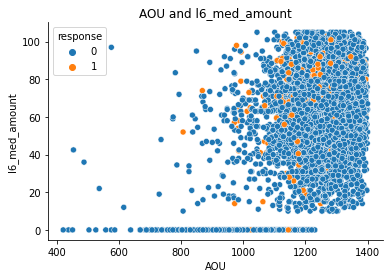

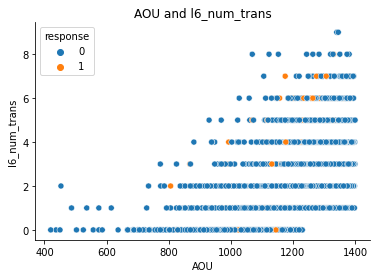

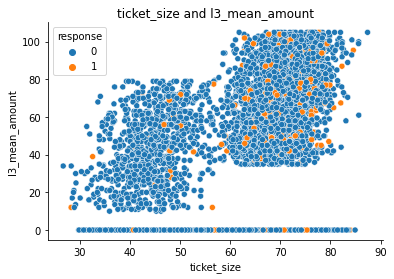

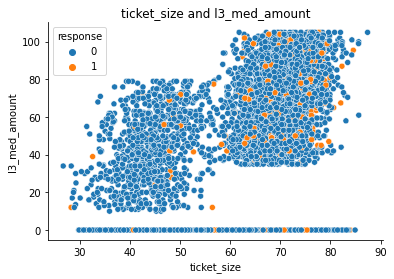

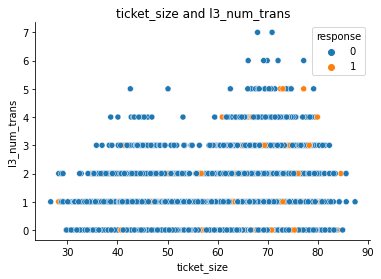

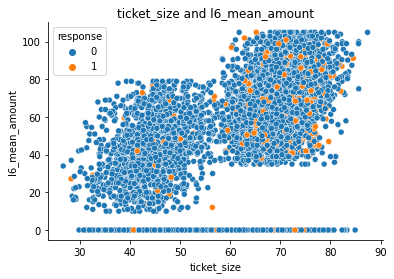

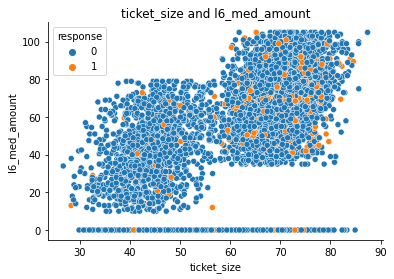

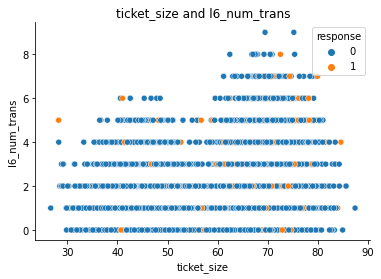

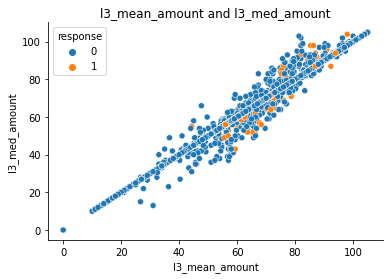

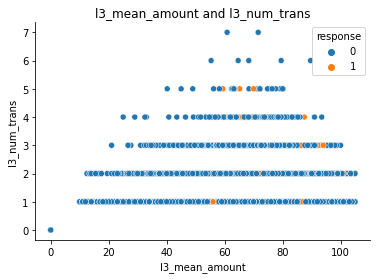

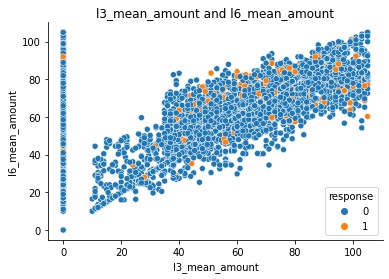

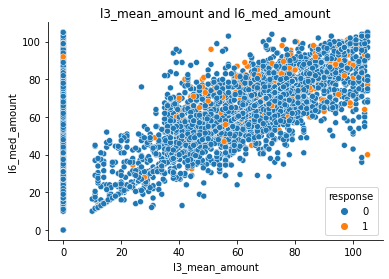

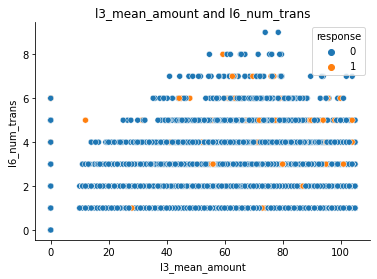

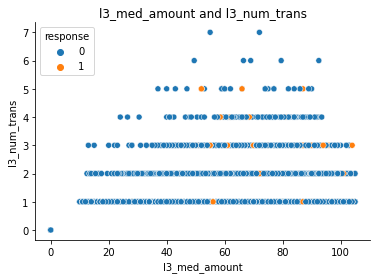

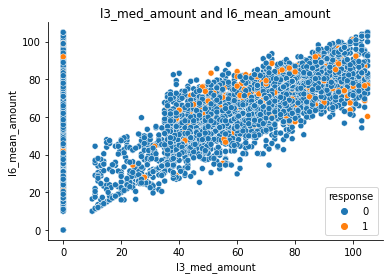

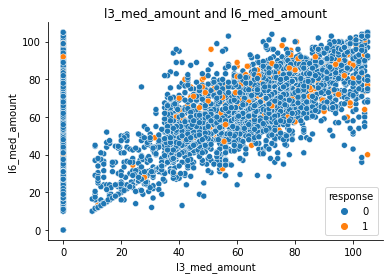

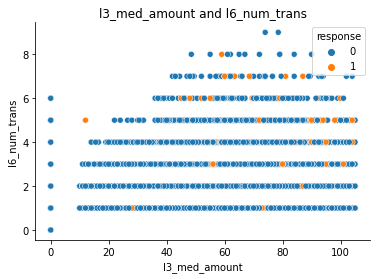

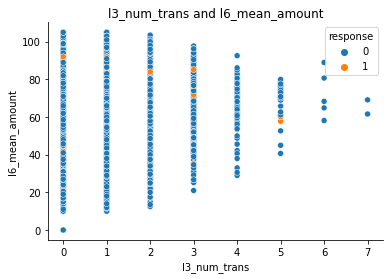

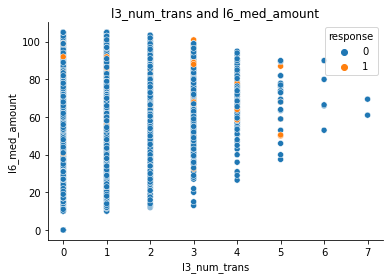

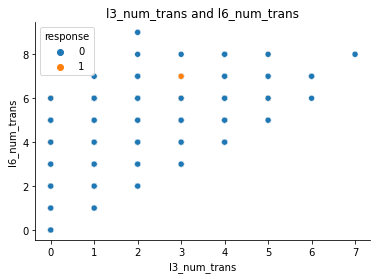

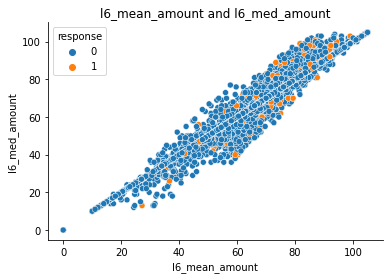

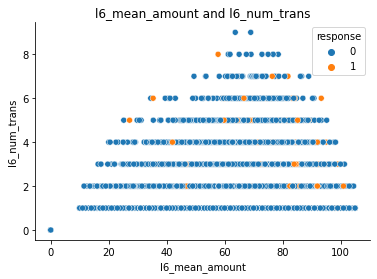

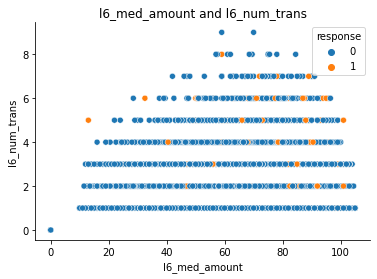

In [23]:
for i, col_i in enumerate(df_modeling_new[[
                                          'recency', 'frequency', 'monetary_value',
                                          'AOU', 'ticket_size', 'l3_mean_amount', 'l3_med_amount', 'l3_num_trans',
                                          'l6_mean_amount', 'l6_med_amount', 'l6_num_trans']].columns):
  for j, col_j in enumerate(df_modeling_new[['recency', 'frequency', 'monetary_value',
                                          'AOU', 'ticket_size', 'l3_mean_amount', 'l3_med_amount', 'l3_num_trans',
                                          'l6_mean_amount', 'l6_med_amount', 'l6_num_trans']].columns):
    if i < j :
      plt.title(col_i + ' and ' + col_j)
      sns.scatterplot(data=df_modeling_new, x=col_i, y=col_j, hue='response')
      sns.despine()
      plt.show()

## **Fixing imbalanced with SMOTE**

In [45]:
sm = SMOTE(random_state=0)

sm.fit(X_train_rfm, y_train_rfm)
X_SMOTE_rfm, y_SMOTE_rfm = sm.fit_sample(X_train_rfm, y_train_rfm)

sm.fit(X_train_clv, y_train_clv)
X_SMOTE_clv, y_SMOTE_clv = sm.fit_sample(X_train_clv, y_train_clv)

sm.fit(X_train_new, y_train_new)
X_SMOTE_new, y_SMOTE_new = sm.fit_sample(X_train_new, y_train_new)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


## **Logistic Regression**

In [46]:
print('logistic regression model - SMOTE RFM')
logreg = LogisticRegression(solver='liblinear', class_weight='balanced')
predicted_y = []
expected_y = []

logreg_model_SMOTE_rfm = logreg.fit(X_SMOTE_rfm, y_SMOTE_rfm)
predictions = logreg_model_SMOTE_rfm.predict(X_SMOTE_rfm)
predicted_y.extend(predictions)
expected_y.extend(y_SMOTE_rfm)
report_train = classification_report(expected_y, predicted_y)
print('training set')
print(report_train) 

predicted_y = []
expected_y = []
predictions = logreg_model_SMOTE_rfm.predict(X_test_rfm)
predicted_y.extend(predictions)
expected_y.extend(y_test_clv)
report_test = classification_report(expected_y, predicted_y)
print('test set')
print(report_test) 

auc_train = roc_auc_score(y_SMOTE_rfm, logreg_model_SMOTE_rfm.predict_proba(X_SMOTE_rfm)[:,1])
print(auc_train)
auc_test = roc_auc_score(y_test_rfm, logreg_model_SMOTE_rfm.predict_proba(X_test_rfm)[:,1])
print(auc_test)

logistic regression model - SMOTE RFM
training set
              precision    recall  f1-score   support

           0       0.68      0.62      0.65      4389
           1       0.65      0.71      0.68      4389

    accuracy                           0.67      8778
   macro avg       0.67      0.67      0.67      8778
weighted avg       0.67      0.67      0.67      8778

test set
              precision    recall  f1-score   support

           0       0.95      0.63      0.75      1848
           1       0.18      0.71      0.29       218

    accuracy                           0.64      2066
   macro avg       0.57      0.67      0.52      2066
weighted avg       0.87      0.64      0.71      2066

0.7196147279069898
0.7231050677151593


In [47]:
print('logistic regression model - SMOTE CLV')
logreg = LogisticRegression(solver='liblinear', class_weight='balanced')
predicted_y = []
expected_y = []

logreg_model_SMOTE_clv = logreg.fit(X_SMOTE_clv, y_SMOTE_clv)
predictions = logreg_model_SMOTE_clv.predict(X_SMOTE_clv)
predicted_y.extend(predictions)
expected_y.extend(y_SMOTE_clv)
report_train = classification_report(expected_y, predicted_y)
print('training set')
print(report_train) 

predicted_y = []
expected_y = []
predictions = logreg_model_SMOTE_clv.predict(X_test_clv)
predicted_y.extend(predictions)
expected_y.extend(y_test_clv)
report_test = classification_report(expected_y, predicted_y)
print('test set')
print(report_test) 

auc_train = roc_auc_score(y_SMOTE_clv, logreg_model_SMOTE_clv.predict_proba(X_SMOTE_clv)[:,1])
print(auc_train)
auc_test = roc_auc_score(y_test_clv, logreg_model_SMOTE_clv.predict_proba(X_test_clv)[:,1])
print(auc_test)

logistic regression model - SMOTE CLV
training set
              precision    recall  f1-score   support

           0       0.68      0.62      0.65      4389
           1       0.65      0.71      0.68      4389

    accuracy                           0.67      8778
   macro avg       0.67      0.67      0.67      8778
weighted avg       0.67      0.67      0.67      8778

test set
              precision    recall  f1-score   support

           0       0.95      0.62      0.75      1848
           1       0.18      0.72      0.29       218

    accuracy                           0.63      2066
   macro avg       0.57      0.67      0.52      2066
weighted avg       0.87      0.63      0.70      2066

0.719488088268892
0.7308471345168593


In [48]:
print('logistic regression model - SMOTE NEW')
logreg = LogisticRegression(solver='liblinear', class_weight='balanced')
predicted_y = []
expected_y = []

logreg_model_SMOTE_new = logreg.fit(X_SMOTE_new, y_SMOTE_new)
predictions = logreg_model_SMOTE_new.predict(X_SMOTE_new)
predicted_y.extend(predictions)
expected_y.extend(y_SMOTE_new)
report_train = classification_report(expected_y, predicted_y)
print('training set')
print(report_train) 

predicted_y = []
expected_y = []
predictions = logreg_model_SMOTE_new.predict(X_test_new)
predicted_y.extend(predictions)
expected_y.extend(y_test_new)
report_test = classification_report(expected_y, predicted_y)
print('test set')
print(report_test) 


auc_train = roc_auc_score(y_SMOTE_new, logreg_model_SMOTE_new.predict_proba(X_SMOTE_new)[:,1])
print(auc_train)
auc_test = roc_auc_score(y_test_new, logreg_model_SMOTE_new.predict_proba(X_test_new)[:,1])
print(auc_test)

logistic regression model - SMOTE NEW
training set
              precision    recall  f1-score   support

           0       0.70      0.66      0.68      4389
           1       0.68      0.72      0.70      4389

    accuracy                           0.69      8778
   macro avg       0.69      0.69      0.69      8778
weighted avg       0.69      0.69      0.69      8778

test set
              precision    recall  f1-score   support

           0       0.95      0.67      0.78      1848
           1       0.21      0.73      0.32       218

    accuracy                           0.67      2066
   macro avg       0.58      0.70      0.55      2066
weighted avg       0.88      0.67      0.74      2066

0.7489158800811136
0.7538350411056832


## **XGBoost**

In [49]:
print('XGBoost model - SMOTE RFM')

xgb_model = xgb.XGBClassifier(objective='binary:logistic', eval_metric='auc',
 learning_rate =0.01,
 n_estimators=100,
 max_depth=2,
 gamma=0.0,
 colsample_bytree=0.6)

predicted_y = []
expected_y = []

xgb_model_SMOTE_rfm = xgb_model.fit(X_SMOTE_rfm, y_SMOTE_rfm, early_stopping_rounds=5, eval_set=[(X_test_rfm.to_numpy(), y_test_rfm)])
predictions =  xgb_model_SMOTE_rfm.predict(X_SMOTE_rfm)
predicted_y.extend(predictions)
expected_y.extend(y_SMOTE_rfm)
report_train = classification_report(expected_y, predicted_y)
print('training set')
print(report_train) 

predicted_y = []
expected_y = []
predictions = xgb_model_SMOTE_rfm.predict(X_test_rfm.to_numpy())
predicted_y.extend(predictions)
expected_y.extend(y_test_rfm)
report_test = classification_report(expected_y, predicted_y)
print('test set')
print(report_test) 


auc_train = roc_auc_score(y_SMOTE_rfm, xgb_model_SMOTE_rfm.predict_proba(X_SMOTE_rfm)[:,1])
print(auc_train)
auc_test = roc_auc_score(y_test_rfm, xgb_model_SMOTE_rfm.predict_proba(X_test_rfm.to_numpy())[:,1])
print(auc_test)

XGBoost model - SMOTE RFM
[0]	validation_0-auc:0.567615
Will train until validation_0-auc hasn't improved in 5 rounds.
[1]	validation_0-auc:0.713189
[2]	validation_0-auc:0.709773
[3]	validation_0-auc:0.69828
[4]	validation_0-auc:0.711449
[5]	validation_0-auc:0.713189
[6]	validation_0-auc:0.708296
Stopping. Best iteration:
[1]	validation_0-auc:0.713189

training set
              precision    recall  f1-score   support

           0       0.75      0.57      0.65      4389
           1       0.65      0.81      0.72      4389

    accuracy                           0.69      8778
   macro avg       0.70      0.69      0.69      8778
weighted avg       0.70      0.69      0.69      8778

test set
              precision    recall  f1-score   support

           0       0.96      0.57      0.71      1848
           1       0.18      0.79      0.29       218

    accuracy                           0.59      2066
   macro avg       0.57      0.68      0.50      2066
weighted avg       0.88 

In [50]:
print('XGBoost model - SMOTE CLV')

xgb_model = xgb.XGBClassifier(objective='binary:logistic', eval_metric='auc',
 learning_rate =0.01,
 n_estimators=100,
 max_depth=2,
 gamma=0.0,
 colsample_bytree=0.6)

predicted_y = []
expected_y = []

xgb_model_SMOTE_clv = xgb_model.fit(X_SMOTE_clv, y_SMOTE_clv, early_stopping_rounds=5, eval_set=[(X_test_clv.to_numpy(), y_test_clv)])
predictions =  xgb_model_SMOTE_clv.predict(X_SMOTE_clv)
predicted_y.extend(predictions)
expected_y.extend(y_SMOTE_clv)
report_train = classification_report(expected_y, predicted_y)
print('training set')
print(report_train) 

predicted_y = []
expected_y = []
predictions = xgb_model_SMOTE_clv.predict(X_test_clv.to_numpy())
predicted_y.extend(predictions)
expected_y.extend(y_test_clv)
report_test = classification_report(expected_y, predicted_y)
print('test set')
print(report_test)

auc_train = roc_auc_score(y_SMOTE_clv, xgb_model_SMOTE_clv.predict_proba(X_SMOTE_clv)[:,1])
print(auc_train)
auc_test = roc_auc_score(y_test_clv, xgb_model_SMOTE_clv.predict_proba(X_test_clv.to_numpy())[:,1])
print(auc_test)

XGBoost model - SMOTE CLV
[0]	validation_0-auc:0.68482
Will train until validation_0-auc hasn't improved in 5 rounds.
[1]	validation_0-auc:0.717808
[2]	validation_0-auc:0.724408
[3]	validation_0-auc:0.725875
[4]	validation_0-auc:0.723803
[5]	validation_0-auc:0.726727
[6]	validation_0-auc:0.72539
[7]	validation_0-auc:0.724427
[8]	validation_0-auc:0.723888
[9]	validation_0-auc:0.724839
[10]	validation_0-auc:0.724921
Stopping. Best iteration:
[5]	validation_0-auc:0.726727

training set
              precision    recall  f1-score   support

           0       0.77      0.55      0.64      4389
           1       0.65      0.84      0.73      4389

    accuracy                           0.70      8778
   macro avg       0.71      0.70      0.69      8778
weighted avg       0.71      0.70      0.69      8778

test set
              precision    recall  f1-score   support

           0       0.96      0.55      0.70      1848
           1       0.17      0.80      0.28       218

    accuracy

In [57]:
print('XGBoost model - SMOTE NEW')

xgb_model = xgb.XGBClassifier(objective='binary:logistic', eval_metric='auc',
 learning_rate =0.01,
 n_estimators=100,
 max_depth=2,
 gamma=0.0,
 colsample_bytree=0.6)

predicted_y = []
expected_y = []

xgb_model_SMOTE_new = xgb_model.fit(X_SMOTE_new, y_SMOTE_new, early_stopping_rounds=500, eval_set=[(X_test_new.to_numpy(), y_test_new)])
predictions =  xgb_model_SMOTE_new.predict(X_SMOTE_new)
predicted_y.extend(predictions)
expected_y.extend(y_SMOTE_new)
report_train = classification_report(expected_y, predicted_y)
print('training set')
print(report_train) 

predicted_y = []
expected_y = []
predictions = xgb_model_SMOTE_new.predict(X_test_new.to_numpy())
predicted_y.extend(predictions)
expected_y.extend(y_test_new)
report_test = classification_report(expected_y, predicted_y)
print('test set')
print(report_test) 

auc_train = roc_auc_score(y_SMOTE_new, xgb_model_SMOTE_new.predict_proba(X_SMOTE_new)[:,1])
print('auc_train: ',auc_train)
auc_test = roc_auc_score(y_test_new, xgb_model_SMOTE_new.predict_proba(X_test_new.to_numpy())[:,1])
print('auc_test: ',auc_test)

XGBoost model - SMOTE NEW
[0]	validation_0-auc:0.643995
Will train until validation_0-auc hasn't improved in 500 rounds.
[1]	validation_0-auc:0.729038
[2]	validation_0-auc:0.730269
[3]	validation_0-auc:0.726143
[4]	validation_0-auc:0.729824
[5]	validation_0-auc:0.736319
[6]	validation_0-auc:0.734373
[7]	validation_0-auc:0.736363
[8]	validation_0-auc:0.737316
[9]	validation_0-auc:0.739711
[10]	validation_0-auc:0.737915
[11]	validation_0-auc:0.733477
[12]	validation_0-auc:0.734959
[13]	validation_0-auc:0.735126
[14]	validation_0-auc:0.733805
[15]	validation_0-auc:0.732762
[16]	validation_0-auc:0.732752
[17]	validation_0-auc:0.731913
[18]	validation_0-auc:0.732819
[19]	validation_0-auc:0.730968
[20]	validation_0-auc:0.731519
[21]	validation_0-auc:0.733175
[22]	validation_0-auc:0.732699
[23]	validation_0-auc:0.73353
[24]	validation_0-auc:0.73323
[25]	validation_0-auc:0.73322
[26]	validation_0-auc:0.733131
[27]	validation_0-auc:0.733014
[28]	validation_0-auc:0.732808
[29]	validation_0-auc:0

In [52]:
## building pipeline for hyperparameter tuning

from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, chi2

# Create a pipeline
pipe = Pipeline([
  ('fs', SelectKBest()),
  ('clf', xgb.XGBClassifier(objective='binary:logistic', scale_pos_weight=9))
])

In [53]:
## hyper parameter tuning - grid search

from sklearn.model_selection import KFold, GridSearchCV
from sklearn.metrics import accuracy_score, make_scorer
# Define our search space for grid search
search_space = [
  {
    'clf__n_estimators': [100, 300],
    'clf__learning_rate': [0.01, 0.1],
    'clf__max_depth': range(2, 5),
    'clf__colsample_bytree': [i/10.0 for i in range(4, 7)],
    'clf__gamma': [i/10.0 for i in range(3)],
    'fs__score_func': [chi2],
    'fs__k': [2],
  }
]
# Define cross validation
kfold = KFold(n_splits=5, random_state=42)
# AUC and F1 as score
scoring = {'AUC':'roc_auc','F1 score': 'f1_micro'}
# Define grid search
grid = GridSearchCV(
  pipe,
  param_grid=search_space,
  cv=kfold,
  scoring=scoring,
  refit='AUC',
  verbose=1,
  n_jobs=-1
)

# Fit grid search
xgb_model_new_GS = grid.fit(X_train_new, y_train_new)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    8.8s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:   38.4s
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 540 out of 540 | elapsed:  1.8min finished


In [54]:
predicted_y = []
expected_y = []
predictions = xgb_model_new_GS.predict(X_test_new)
print('Best AUC Score: {}'.format(xgb_model_new_GS.best_score_))
print(confusion_matrix(y_test_new,predictions))


predicted_y.extend(predictions)
expected_y.extend(y_test_new)
report_test = classification_report(expected_y, predicted_y)
print('test set')
print(report_test) 

Best AUC Score: 0.7010230754960689
[[1056  792]
 [  59  159]]
test set
              precision    recall  f1-score   support

           0       0.95      0.57      0.71      1848
           1       0.17      0.73      0.27       218

    accuracy                           0.59      2066
   macro avg       0.56      0.65      0.49      2066
weighted avg       0.86      0.59      0.67      2066



In [55]:
print(xgb_model_new_GS.best_params_)

{'clf__colsample_bytree': 0.4, 'clf__gamma': 0.0, 'clf__learning_rate': 0.01, 'clf__max_depth': 2, 'clf__n_estimators': 100, 'fs__k': 2, 'fs__score_func': <function chi2 at 0x7fc76280b7a0>}
